# Understanding Attention

This notebook provides a complete code example that demonstrates how the attention mechanism works.

In [1]:
query_sentence = "The teacher praised a student because she improved"
key_sentence = "A student asked the teacher to help her improving"

In [2]:
query_tokens = query_sentence.lower().split()
key_tokens = key_sentence.lower().split()

In [3]:
print(query_tokens)
print(key_tokens)

['the', 'teacher', 'praised', 'a', 'student', 'because', 'she', 'improved']
['a', 'student', 'asked', 'the', 'teacher', 'to', 'help', 'her', 'improving']


In [5]:
import os
from torchvision.datasets.utils import download_url, extract_archive

glove_folder = os.path.join(".", ".glove_cache")
zip_filepath = os.path.join(glove_folder, "glove.42B.300d.zip")
if not os.path.exists(glove_folder):
    os.makedirs(glove_folder, exist_ok=True)
    url = "https://nlp.stanford.edu/data/glove.42B.300d.zip"
    download_url(url, glove_folder)
    extract_archive(zip_filepath, glove_folder)
    os.remove(zip_filepath)

In [16]:
import numpy as np
import torch

In [17]:
def load_glove_embeddings(file_path):
    """Load GloVe embeddings."""
    glove_embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            glove_embeddings[word] = np.round(
                np.asarray(values[1:], dtype='float32'), decimals=6,
            )
    return glove_embeddings

In [18]:
def get_glove_embeddings(vocab, glove_embeddings, embedding_dim):
    """Get embeddings for a vocabulary using GloVe."""
    embeddings_matrix = \
        torch.zeros((len(vocab), embedding_dim), dtype=torch.float32)
    for i, token in enumerate(vocab):
        embedding = glove_embeddings.get(token)
        if embedding is None:
            embedding = glove_embeddings.get(token.lower())
        if embedding is not None:
            embedding = torch.tensor(embedding, dtype=torch.float32)
            embeddings_matrix[i] = embedding
    return embeddings_matrix

In [19]:
glove_file = os.path.join(glove_folder, "glove.42B.300d.txt")
glove_embed, embed_dim = load_glove_embeddings(glove_file), 300

In [20]:
query_embeddings = get_glove_embeddings(query_tokens, glove_embed, embed_dim)
key_embeddings = get_glove_embeddings(key_tokens, glove_embed, embed_dim)

In [23]:
import deeplay as dl
import torch

class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""
    
    def __init__(self):
        """Initialize dot-product attention."""
        super().__init__()

    def forward(self, queries, keys, values):
        """Calculate dot-product attention."""
        attn_scores = (torch.matmul(queries, keys.transpose(-2, -1))
                       / (keys.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix

In [24]:
attention = DotProductAttention()
attn_output, attn_matrix = attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)

In [25]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import FixedLocator

def plot_attention(query_tokens, key_tokens, attn_matrix):
    """Plot attention."""
    fig, ax = plt.subplots()
    cax = ax.matshow(attn_matrix, cmap="bone")
    fig.colorbar(cax)

    ax.xaxis.set_major_locator(FixedLocator(range(len(key_tokens))))
    ax.yaxis.set_major_locator(FixedLocator(range(len(query_tokens))))
    ax.set_xticklabels(key_tokens, rotation=90)
    ax.set_yticklabels(query_tokens)

    plt.show()

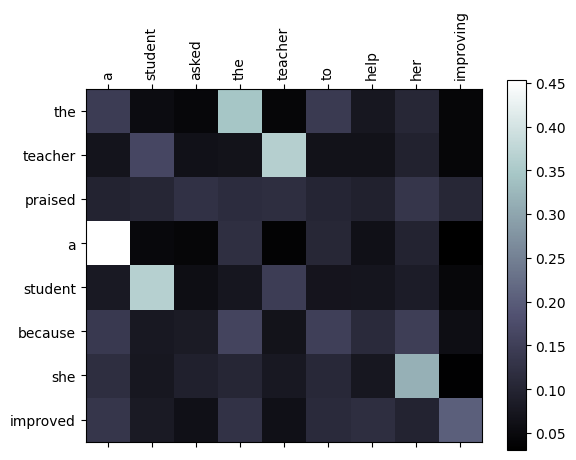

In [26]:
plot_attention(query_tokens=query_tokens, key_tokens=key_tokens, 
               attn_matrix=attn_matrix.detach().squeeze())

In [27]:
import deeplay as dl
import torch

class TrainableAttention(dl.DeeplayModule):
    """Trainable dot-product attention."""
    
    def __init__(self, num_in_features=300, num_out_features=256):
        """Initialize trainable dot-product attention."""
        super().__init__()
        self.Wq = torch.nn.Linear(num_in_features, num_out_features)
        self.Wk = torch.nn.Linear(num_in_features, num_out_features)
        self.Wv = torch.nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        """Calculate dot-product attention with linear transformations."""
        Q, K, V = self.Wq(queries), self.Wk(keys), self.Wv(values)
        attn_scores = (torch.matmul(Q, K.transpose(-2, -1))
                       / (K.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, V)
        return attn_output, attn_matrix

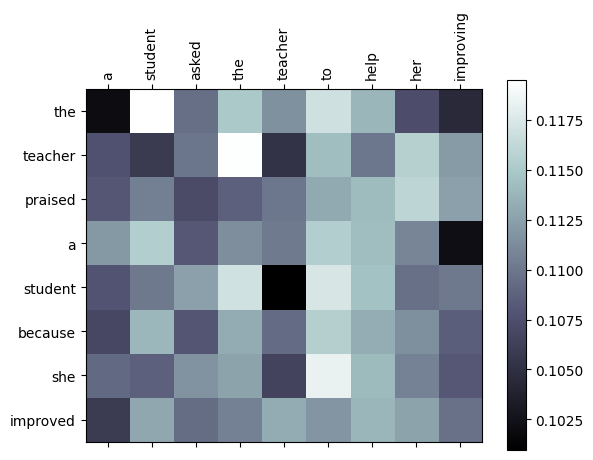

In [37]:
trainable_attention = TrainableAttention()
attn_output, attn_matrix = trainable_attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)
plot_attention(query_tokens=query_tokens, key_tokens=key_tokens, 
               attn_matrix=attn_matrix.detach().squeeze())

In [38]:
import deeplay as dl
import torch

class AdditiveAttention(dl.DeeplayModule):
    """Additive attention."""
    
    def __init__(self, num_in_features=300, num_out_features=256):
        """Initialize additive attention."""
        super().__init__()
        self.Wq = torch.nn.Linear(num_in_features, num_out_features)
        self.Wk = torch.nn.Linear(num_in_features, num_out_features)
        self.Ws = torch.nn.Linear(num_in_features, 1)

    def forward(self, queries, keys, values):
        """Calculate dot-product attention with linear transformations."""
        Q, K, V = self.Wq(queries), self.Wk(keys), values
        attn_scores = torch.tanh(Q + K)
        attn_scores = self.Ws(attn_scores)
        attn_scores = attn_scores.transpose(-2, -1)
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, V)
        return attn_output, attn_matrix

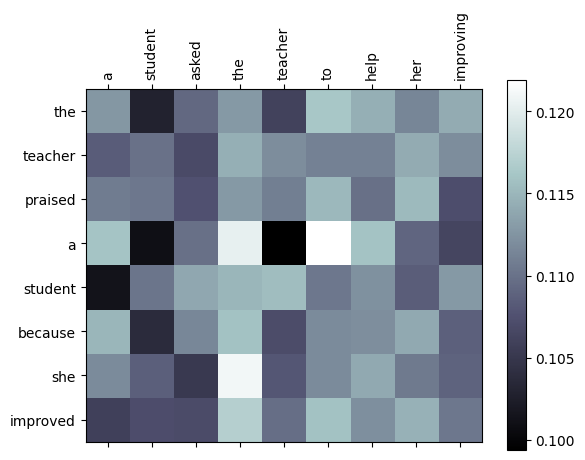

In [39]:
trainable_attention = TrainableAttention()
attn_output, attn_matrix = trainable_attention(
    queries=query_embeddings, keys=key_embeddings, values=key_embeddings,
)
plot_attention(query_tokens=query_tokens, key_tokens=key_tokens, 
               attn_matrix=attn_matrix.detach().squeeze())

## Obtaining a matrix representation of sentences

Use randomly generated embeddings to represent each word ...

In [1]:
import torch
import numpy as np

in_sentence= "The teacher praised the student because she improved"

in_tokens = in_sentence.split()
embeddings = {token: np.random.rand(300) for token in in_tokens}
in_embeddings = np.array([embeddings[token] for token in in_tokens])
in_embeddings = torch.tensor(in_embeddings, dtype=torch.float).unsqueeze(0)

## Implement Dot-product Attention

In [2]:
import torch.nn.functional as F
import deeplay as dl


class DotProductAttention(dl.DeeplayModule):
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys, values):
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1))  \
             / (keys.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1) 
        attn_output = torch.matmul(attn_weights, values) 
        return attn_output, attn_weights

Calculate self-attention for the example

In [3]:
attention = DotProductAttention()

queries = in_embeddings
keys = in_embeddings
values = in_embeddings

attn_output, attn_weights = attention(queries, keys, values)

attn_matrix = attn_weights.detach().squeeze()

Define a function to visualize the attention matrix as a heatmap. 

In [4]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import FixedLocator

def plot_attention(in_tokens, out_tokens, attn_matrix, specials = None):

    if specials is None:
        specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

    if specials[1] in in_tokens:
        in_tokens = in_tokens[1:]
        out_tokens = out_tokens[:-1]
        attn_matrix = attn_matrix[:-1, 1:] 

    eos_in_index = in_tokens.index(specials[2]) if specials[2] in in_tokens else len(in_tokens)
    eos_out_index = out_tokens.index(specials[2]) if specials[2] in out_tokens else len(out_tokens)

    cut_index = max(eos_in_index, eos_out_index)
    filtered_in_tokens = in_tokens[:cut_index]
    filtered_out_tokens = out_tokens[:cut_index]
    filtered_attn_matrix = attn_matrix[:cut_index, :cut_index]

    fig, ax = plt.subplots()
    cax = ax.matshow(filtered_attn_matrix, cmap="bone")
    fig.colorbar(cax)

    ax.xaxis.set_major_locator(FixedLocator(range(len(filtered_in_tokens))))
    ax.yaxis.set_major_locator(FixedLocator(range(len(filtered_out_tokens))))
    ax.set_xticklabels(filtered_in_tokens, rotation=90)
    ax.set_yticklabels(filtered_out_tokens)

    ###  plt.savefig("fig_08_Xn.pdf")  
    plt.show()

... and plot the attention.

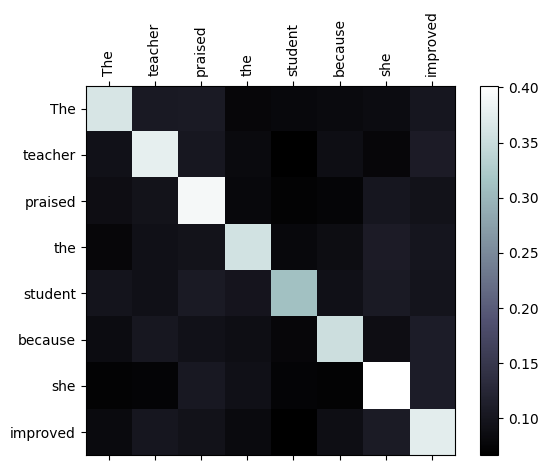

In [5]:
plot_attention(in_tokens, in_tokens, attn_matrix)

## Exercise
Shuffle and crop the sentence and calculate cross-attention with the original sentence 

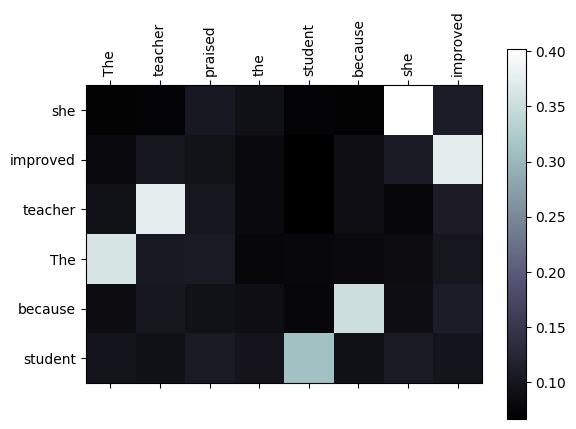

In [6]:
import numpy as np

crop_length = 6
indices = np.random.choice(len(in_tokens), crop_length, replace=False)

shuffled_tokens = [in_tokens[i] for i in indices] 
shuffled_embeddings = in_embeddings[:, indices, :]

queries = shuffled_embeddings

attn_output, attn_weights = attention(queries, keys, values)
attn_matrix = attn_weights.detach().squeeze()

plot_attention(in_tokens, shuffled_tokens, attn_matrix)

## Defining Other Forms of Attention

Prepare a class implementing standard scaled dot-product attention ...

In [7]:
import torch.nn as nn


class StandardAttention(dl.DeeplayModule):

    def __init__(self, num_in_features=128, num_out_features=256):
        super().__init__()
        self.Wq = nn.Linear(num_in_features, num_out_features)
        self.Wk = nn.Linear(num_in_features, num_out_features)
        self.Wv = nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        Q = self.Wq(queries)
        K = self.Wk(keys) 
        V = self.Wv(values)  
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1))  \
            / (K.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights

... general attention (Luong) ...

In [8]:
class GeneralAttention(dl.DeeplayModule):


    def __init__(self, num_in_features=128, num_out_features=128):
        super().__init__()
        self.Wk = nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        Q = queries
        K = self.Wk(keys) 
        V = values
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) \
            / (K.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights

... and additive attention (Bahdanau).

In [9]:
class AdditiveAttention(dl.DeeplayModule):


    def __init__(self, num_in_features=128, num_out_features=256):
        super().__init__()
        self.Wq = nn.Linear(num_in_features, num_out_features)
        self.Wk = nn.Linear(num_in_features, num_out_features)
        self.Ws = nn.Linear(num_out_features, 1)

    def forward(self, queries, keys, values):
        Q = self.Wq(queries)
        K = self.Wk(keys) 
        V = values

        attn_scores = torch.tanh(Q + K)
        attn_scores = self.Ws(attn_scores)

        attn_scores = attn_scores.transpose(-2, -1)
        attn_weights = F.softmax(attn_scores, dim=-1)

        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights